# The transient universe

In [1]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from scipy.stats import uniform
from scipy.stats import norm
from scipy.optimize import minimize
import emcee
from scipy import optimize
import corner
from IPython.display import display, Math
import statistics

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['font.size'] = 12

I read in solution/transient.npy. This is a (100 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

In [2]:
data = np.load('transient.npy')
time = data[:,0]
flux = data[:,1]
flux_err = data[:,2]

First look at the data

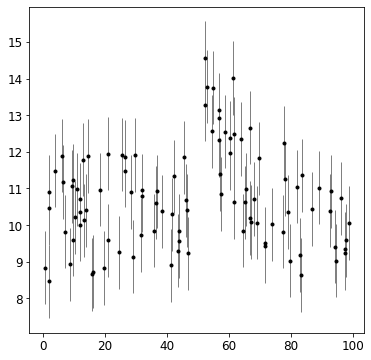

In [3]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.errorbar(time, flux, flux_err, 
            fmt='.k', lw=1, ecolor='gray');

One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:
<center> $y = b, for \ t \ < \ t_0$ </center>
<center> $y = b + Ae^{-\alpha (t-t_0)}, for \ t \ > \ t_0$ </center>
where $\textbf{b}$, is the background amplitude, $\textbf{A}$ is the burst amplitude, $\textbf{t_0}$ is the burst epoch, and $\textbf{\alpha}$ encodes how rapidly the burst dies off.

In [4]:
def model(time, A, b, t_0, alpha):
    model_array = []
        
    for t in time:     
        
        if t<t_0:
            model_array.append(b)
        else:
            model_array.append(b + A*np.exp(-alpha*(t-t_0)))
    
    return model_array

'b = uniform.rvs(0, 50)\nA = uniform.rvs(0, 50)\nt_0 = uniform.rvs(0, 100)\nalpha = np.exp(uniform.rvs(-5,5))'

In [5]:
# Fitting for the parameters through Least-Squared
def squared_loss (A, b, t_0, alpha, time, flux, flux_err):
    return np.sum(((flux - model(time, A, b, t_0, alpha)) / flux_err)**2, -1)

f_squared = lambda beta: squared_loss(beta[0], beta[1], beta[2], beta[3], time, flux, flux_err)
beta0 = (5, 10, 50, 0.1)
beta_squared = optimize.fmin(f_squared, beta0)
popt = beta_squared

Optimization terminated successfully.
         Current function value: 97.504517
         Iterations: 110
         Function evaluations: 199


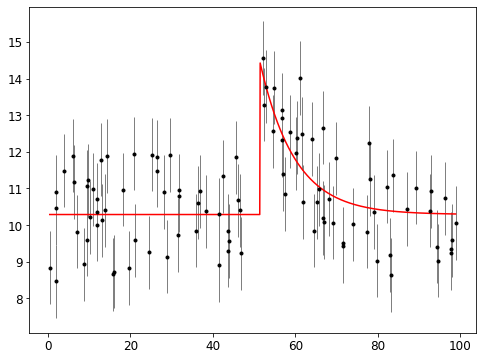

In [21]:
plt.figure(figsize=(8, 6))
plt.errorbar(time, flux, flux_err, fmt='.k', lw=1, ecolor='gray')
N = 1000
x_fit = np.linspace(min(time), max(time), N)
plt.plot(x_fit, model(x_fit, popt[0], popt[1], popt[2], popt[3]),  color = 'red');

# Likelihood estimation

In [7]:
# prior parameters
A = popt[0]
b = popt[1]
t_0 = popt[2]
alpha = popt[3]
print(popt)

[ 4.18444201 10.28787654 51.37697149  0.11890527]


In [8]:
def log_likelihood(theta, time, flux, flux_err):
    A, b, t_0, alpha = theta
    return -0.5 * np.sum((flux - model(time, A, b, t_0, alpha)) ** 2 / flux_err + np.log(flux_err))

def log_prior(theta):
    A, b, t_0, alpha = theta
    if 0.0 < A < 50.0 and 0.0 < b < 50.0 and 0.0 < t_0 < 100.0 and -5.0 < np.log(alpha) < 5.0:
        return 0.0
    
    return -np.inf

def log_probability(theta, time, flux, flux_err):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, time, flux, flux_err)

In [9]:
pos = popt + 1e-4 * np.random.randn(32, 4)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args = (time, flux, flux_err))
sampler.run_mcmc(pos, 5000, progress=True);

  1%|          | 49/5000 [00:00<00:42, 117.68it/s]C:\Users\loren\AppData\Local\Temp\ipykernel_14648\1131865792.py:7: RuntimeWarning: invalid value encountered in log
  if 0.0 < A < 50.0 and 0.0 < b < 50.0 and 0.0 < t_0 < 100.0 and -5.0 < np.log(alpha) < 5.0:
100%|██████████| 5000/5000 [00:43<00:00, 115.72it/s]


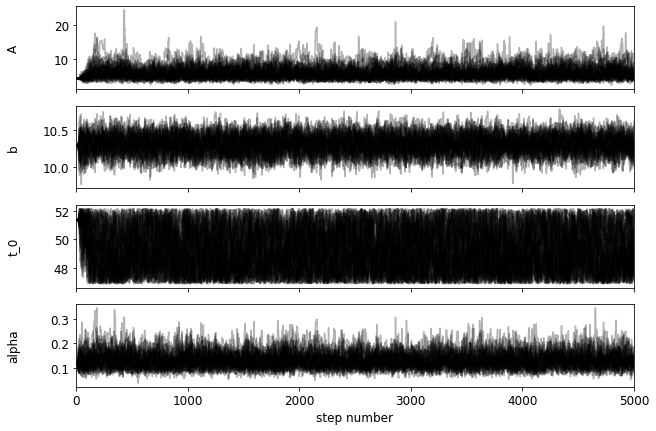

In [10]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels_param = ["A", "b", "t_0", "alpha"] 
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels_param[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [11]:
tau = sampler.get_autocorr_time()
print(tau)

[65.99503276 56.19290538 65.13764466 57.59359477]


In [12]:
flat_samples = sampler.get_chain(discard=100, thin=int(np.mean(tau)), flat=True)
print(flat_samples.shape)

(2560, 4)


In [13]:
quantile_values_68 = np.percentile(flat_samples, 68, axis=0)
quantile_values_95 = np.percentile(flat_samples, 95, axis=0)

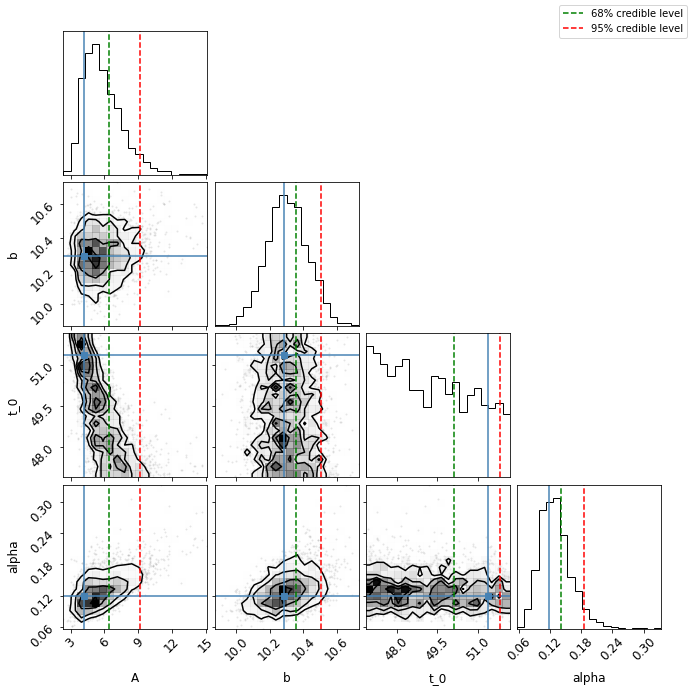

In [15]:
fig = corner.corner(
    flat_samples, labels=labels_param, truths=[A, b, t_0, alpha]
)

axes = np.array(fig.axes).reshape((ndim, ndim))

for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(quantile_values_68[i], color="g", linestyle='dashed')
    ax.axvline(quantile_values_95[i], color="r", linestyle='dashed')

# labels
handles = [
    plt.Line2D([], [], color='g', linestyle='--'),
    plt.Line2D([], [], color='r', linestyle='--')
]

labels = ['68% credible level', '95% credible level']

plt.figlegend(handles, labels, loc='upper right', fontsize='small');

In [16]:
# i take some burned data
inds = np.random.randint(len(flat_samples), size=100)

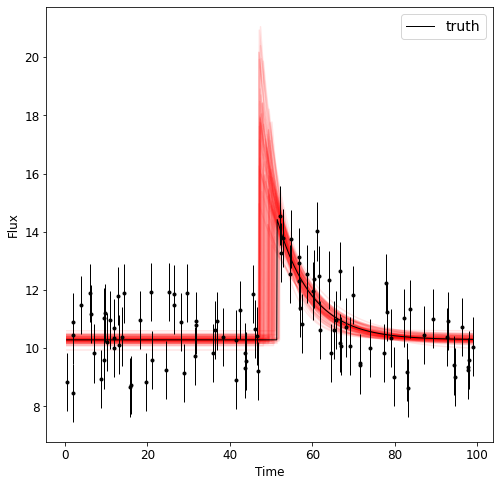

In [22]:
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x_fit, model(x_fit, sample[0], sample[1], sample[2], sample[3]), "r", alpha=0.1)
plt.errorbar(time, flux, yerr=flux_err, fmt=".k", lw=1)
plt.plot(x_fit, model(x_fit, A, b, t_0, alpha), "k", lw=1, label="truth")
plt.legend(fontsize=14)
#plt.xlim(0, 10)
plt.xlabel("Time")
plt.ylabel("Flux");

In [18]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [5, 50, 95])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels_param[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>